# AutoEncoder V3
En este script tratare de hacer el entrenamiento para diferentes dispositivos usando arquitecturas de auto encoders para cada dispositivo. Despues de hacer este entrenamiento la idea es generar un algoritmo que tenga una entrada común a todos ellos pero que cada cual la procese de acuerdo al dispositivo objetivo para el que se ha entrenado. 

In [1]:
#0. Cargar las librerias 
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (13, 6)

# Datos de entrenamiento

In [2]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

In [7]:
#2. Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 512

In [8]:
#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada solo el cero
train_meter = train_elec.submeters()['fridge'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.

In [9]:
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

In [10]:
#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)


In [11]:
mainchunk.head(5)

2011-04-18 09:22:09-04:00    224.190002
2011-04-18 09:22:10-04:00    225.570007
2011-04-18 09:22:11-04:00    226.089996
2011-04-18 09:22:12-04:00    222.740005
2011-04-18 09:22:13-04:00    222.199997
Freq: S, Name: (power, apparent), dtype: float32

In [12]:
#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

4521.0400390625

In [13]:
#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

In [14]:
#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

2011-04-18 09:22:09-04:00    0.049588
2011-04-18 09:22:10-04:00    0.049893
2011-04-18 09:22:11-04:00    0.050008
2011-04-18 09:22:12-04:00    0.049267
2011-04-18 09:22:13-04:00    0.049148
Freq: S, Name: (power, apparent), dtype: float64

In [15]:
#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

In [16]:
#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')


In [17]:
#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

In [18]:
#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

In [19]:
#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

X_batch (1960, 512, 1)
Y_batch (1960, 512, 1)


In [20]:
print(f"X_batch {type(X_batch)}")

X_batch <class 'numpy.ndarray'>


**NOTA:** En este punto ya se han definido las series de datos de entrenamiento para los modelos.

# Modelo
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

In [17]:
# Librerias para modelos
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Reshape, Dropout
from keras.utils import plot_model

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [18]:
def auto_encoder1(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*8, activation='relu'))

    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [19]:
dae = auto_encoder1(sequence_length)

In [20]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
modelo_entrenado = dae.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
62/62 [==============================] - 8s 125ms/step - loss: 4.3865e-04
Epoch 2/25
62/62 [==============================] - 8s 123ms/step - loss: 3.6886e-04
Epoch 3/25
62/62 [==============================] - 8s 123ms/step - loss: 2.8307e-04
Epoch 4/25
62/62 [==============================] - 8s 124ms/step - loss: 2.6407e-04
Epoch 5/25
62/62 [==============================] - 8s 125ms/step - loss: 2.4402e-04
Epoch 6/25
62/62 [==============================] - 8s 124ms/step - loss: 2.5090e-04
Epoch 7/25
62/62 [==============================] - 8s 124ms/step - loss: 2.3455e-04
Epoch 8/25
62/62 [==============================] - 8s 125ms/step - loss: 2.1951e-04
Epoch 9/25
62/62 [==============================] - 8s 121ms/step - loss: 2.5264e-04
Epoch 10/25
62/62 [==============================] - 8s 128ms/step - loss: 2.1428e-04
Epoch 11/25
62/62 [==============================] - 9s 142ms/step - loss: 2.2915e-04
Epoch 12/25
62/62 [==============================] - 8s 124ms/s

In [21]:
dae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 8)            40        
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

# Datos de test

In [22]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['fridge']

Par hacer el correcto entrenamiento es necesario procesar los datos de test, de tal manera que tengamos solo los datos cuando el medidor central funciono de manera adecuada. 

In [23]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [24]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [25]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

Cada tramo de datos que se cargue para test se procesara de manera independiente como una base de datos unica, por lo tanto se deben crear bases para los tramos donde el medidor central funciono bien y tenian datos suficientes para crear al menos una ventana de tiempo con ellos.

In [26]:
def data_predict(mains, id_serie, modelo):
    #Cantidad de pasos en la ventana
    s = sequence_length
    # Tamaño de la sección de la serie que se cargada
    # según los instantes de buen funcionamiento del medidor
    up_limit = len(mains)
    # Rellenar los valores Nan con ceros
    mains.fillna(0, inplace=True)
    # Calcular la cantidad de ceros que deben llenarse 
    # para crear un batch que permita que los datos al 
    # dividirse mantengan el tamaño para todos los datos
    additional = s - (up_limit % s)
    # Crear series de datos con los batch de ceros al final
    X_batch = np.append(mains, np.zeros(additional))
    #Cambiar el formato de los datos como: numero de muestras
    # ventanas de tiempo = 256, y una caracteristica
    X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s ,1))
    #Calcular la prediccion para el modelo
    pred = modelo.predict(X_batch)
    # Ahora une todas las salidas en ventanas a una serie completa, de los cuales solo toma
    # los datos hasta donde la serie original tenia datos. Los datos restantes
    # son los tomados por el batch de ceros, por lo tanto, se eliminan de la predicción
    pred = np.reshape(pred, (up_limit + additional))[:up_limit]
    # Crea una serie de pandas, con los datos de pred, usa como indice los mismos indices de 
    # tiempo que tenia la serie original y como nombre la llama 0 este es un metadato
    column = pd.Series(pred, index=mains.index, name=0)

    # Crea un diccionario vacio con el creara un dataframe posteriormente
    # donde la clave key = 0 tendra como valor value la columna de datos predichos
    appliance_powers_dict = {}
    appliance_powers_dict[0] = column
    # Transforma el diccionario a un dataframe de pandas de esta manera 
    # agrega la dimension de las columnas = 1. Tal que (muestras, 1)
    appliance_powers = pd.DataFrame(appliance_powers_dict)
    # Y es este dataframe el que retorna
    return appliance_powers

In [28]:
output_datastore = pd.HDFStore("predict_V3.h5", "w")
#output_datastore.close()

In [29]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie
    appliance_power = data_predict(chunk2, id_serie, dae)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    output_datastore.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    output_datastore.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [30]:
print(f"output_datastore.keys() {output_datastore.keys()}")
t1 = output_datastore.get('/building1/elec/meter1')
t2 = output_datastore.get('/building1/elec/meter5') #Prediccion
print(f"type(t2) {type(t2)}")
print(f"t2.shape {t2.shape}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter5']
type(t2) <class 'pandas.core.frame.DataFrame'>
t2.shape (746138, 1)


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


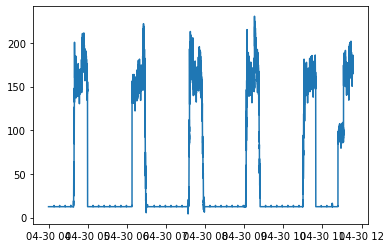

In [31]:
plt.plot(t2[:28000])

In [32]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


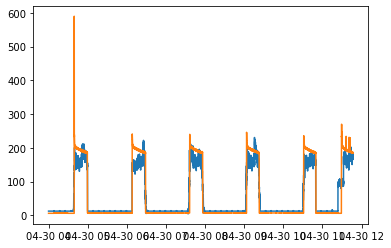

In [33]:
plt.plot(t2[:28000])
plt.plot(test_meter_medidor[:28000])

# 256 pasos en la ventana

In [34]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [35]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['fridge'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

## Modelo 2
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. Modifique el numero de filtros al doble.

In [40]:
def auto_encoder2(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*16, activation='relu'))

    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [41]:
dae2 = auto_encoder2(sequence_length)

In [43]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
modelo_entrenado = dae2.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 9s 73ms/step - loss: 2.4146e-04
Epoch 2/25
123/123 [==============================] - 9s 73ms/step - loss: 2.3299e-04
Epoch 3/25
123/123 [==============================] - 9s 74ms/step - loss: 2.2337e-04
Epoch 4/25
123/123 [==============================] - 9s 74ms/step - loss: 2.1869e-04
Epoch 5/25
123/123 [==============================] - 9s 72ms/step - loss: 2.1247e-04
Epoch 6/25
123/123 [==============================] - 9s 72ms/step - loss: 2.1490e-04
Epoch 7/25
123/123 [==============================] - 9s 72ms/step - loss: 2.1343e-04
Epoch 8/25
123/123 [==============================] - 9s 72ms/step - loss: 2.1769e-04
Epoch 9/25
123/123 [==============================] - 9s 73ms/step - loss: 2.1586e-04
Epoch 10/25
123/123 [==============================] - 9s 72ms/step - loss: 2.0911e-04
Epoch 11/25
123/123 [==============================] - 9s 72ms/step - loss: 1.9864e-04
Epoch 12/25
123/123 [==============================]

In [44]:
dae2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 256, 16)           80        
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

# Datos de test

In [45]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['fridge']

In [46]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [47]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [48]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [50]:
output_datastore2 = pd.HDFStore("predict2_V3.h5", "w")
#output_datastore.close()

In [51]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie >>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae2)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore2 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    output_datastore2.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    output_datastore2.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [52]:
print(f"output_datastore.keys() {output_datastore2.keys()}")
t3 = output_datastore2.get('/building1/elec/meter1')
t4 = output_datastore2.get('/building1/elec/meter5') #Prediccion
print(f"type(t4) {type(t4)}")
print(f"t4.shape {t4.shape}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter5']
type(t4) <class 'pandas.core.frame.DataFrame'>
t4.shape (746138, 1)


In [53]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


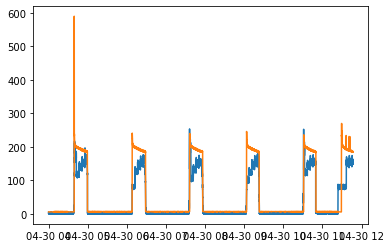

In [54]:
plt.plot(t4[:28000])
plt.plot(test_meter_medidor[:28000])

# Cambiando filtros

In [72]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [73]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['fridge'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

## Modelo 4
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [120]:
def auto_encoder4(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'linear'))
    model.add(Dropout(0.1))    
    #Aplanar la salida
    model.add(Flatten())
    

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 16 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Es un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [121]:
#<<<<
dae4 = auto_encoder4(sequence_length)

In [122]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado4 = dae4.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 10s 75ms/step - loss: 3.7556e-04
Epoch 2/25
123/123 [==============================] - 9s 77ms/step - loss: 2.7479e-04
Epoch 3/25
123/123 [==============================] - 9s 77ms/step - loss: 2.7014e-04
Epoch 4/25
123/123 [==============================] - 10s 79ms/step - loss: 2.3845e-04
Epoch 5/25
123/123 [==============================] - 9s 77ms/step - loss: 2.3720e-04
Epoch 6/25
123/123 [==============================] - 9s 77ms/step - loss: 2.4003e-04
Epoch 7/25
123/123 [==============================] - 9s 77ms/step - loss: 2.2195e-04
Epoch 8/25
123/123 [==============================] - 9s 77ms/step - loss: 2.1215e-04
Epoch 9/25
123/123 [==============================] - 9s 77ms/step - loss: 2.3794e-04
Epoch 10/25
123/123 [==============================] - 9s 77ms/step - loss: 2.4044e-04
Epoch 11/25
123/123 [==============================] - 9s 77ms/step - loss: 2.2663e-04
Epoch 12/25
123/123 [=============================

In [123]:
#<<<<<<
dae4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
dropout_32 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
dense_23 (Dense)             (None, 256, 8)            136       
_________________________________________________________________
dropout_33 (Dropout)         (None, 256, 8)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 4096)             

# Datos de test

In [124]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['fridge']

In [125]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [126]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [127]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [128]:
#output_datastore4.close()

In [129]:
#<<<<<<<
output_datastore4 = pd.HDFStore("predict4_V3.h5", "w")
#output_datastore4.close()

In [130]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie >>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae4)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore4.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore4.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [131]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore4.keys()}")
t7 = output_datastore4.get('/building1/elec/meter1')
t8 = output_datastore4.get('/building1/elec/meter5') #Prediccion
print(f"type(t6) {type(t8)}")
print(f"t6.shape {t8.shape}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter5']
type(t6) <class 'pandas.core.frame.DataFrame'>
t6.shape (746138, 1)


In [132]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


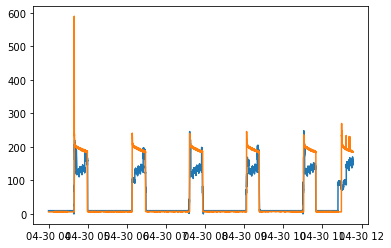

In [133]:
plt.plot(t8[:28000])
plt.plot(test_meter_medidor[:28000])

### Metricas

In [109]:
sections = [TimeFrame(start='2011-04-30 00:00:00-04:00', 
                                    end='2011-05-01 09:44:42-04:00'), 
                          TimeFrame(start='2011-05-01 09:47:18-04:00', 
                                    end='2011-05-02 17:04:59-04:00'), 
                          TimeFrame(start='2011-05-02 17:07:27-04:00', 
                                    end='2011-05-03 17:30:17-04:00'), 
                          TimeFrame(start='2011-05-03 17:32:49-04:00', 
                                    end='2011-05-03 17:33:44-04:00'), 
                          TimeFrame(start='2011-05-06 10:51:46-04:00', 
                                    end='2011-05-07 01:53:10-04:00'), 
                          TimeFrame(start='2011-05-07 01:53:55-04:00', 
                                    end='2011-05-07 02:38:15-04:00'), 
                          TimeFrame(start='2011-05-07 02:40:43-04:00', 
                                    end='2011-05-07 11:59:16-04:00'), 
                          TimeFrame(start='2011-05-11 03:19:43-04:00', 
                                    end='2011-05-12 17:48:38-04:00'), 
                          TimeFrame(start='2011-05-12 20:14:30-04:00', 
                                    end='2011-05-13 05:16:24-04:00'), 
                          TimeFrame(start='2011-05-22 16:04:46-04:00', 
                                    end='2011-05-22 23:39:01-04:00'), 
                          TimeFrame(start='2011-05-22 23:41:35-04:00', 
                                    end='2011-05-23 09:22:08-04:00'), 
                          TimeFrame(start='2011-05-23 10:31:34-04:00', 
                                    end='2011-05-24 14:32:05-04:00'), 
                          TimeFrame(start='2011-05-24 15:55:33-04:00', 
                                    end='2011-05-24 15:57:02-04:00')]

In [110]:
#31. Metricas de rendimiento: Comparación entre lo predicho y lo real
#32. Calcula los valores de tp, fp, fn, tn 
def tp_tn_fp_fn(states_pred, states_ground):
    # Calcula los estados logicos con comparadores and 1 and 1 = True
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

#33. Calcula el recall
def recall(tp,fn):
    return tp/float(tp+fn)
#34. La precision
def precision(tp,fp):
    return tp/float(tp+fp)
#35. El valor f1
def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)
#36. El accuracy
def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

#37. Umbral donde se determina que el dispositivo esta encendido
# para el refrigerador se puede tomar un valor = 20W
threshold = 10

In [114]:
#38. Defino los datos de predicción y test como padans.df
id = 1
#prediccion = t6[sections[id].start:sections[id].end]
prediccion = t6
#real = test_meter_medidor[sections[id].start:sections[id].end]
real = test_meter_medidor
#12. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes
ix = prediccion.index.intersection(real.index)
ix

DatetimeIndex(['2011-04-30 00:00:01-04:00', '2011-04-30 00:00:02-04:00',
               '2011-04-30 00:00:03-04:00', '2011-04-30 00:00:04-04:00',
               '2011-04-30 00:00:05-04:00', '2011-04-30 00:00:06-04:00',
               '2011-04-30 00:00:07-04:00', '2011-04-30 00:00:08-04:00',
               '2011-04-30 00:00:09-04:00', '2011-04-30 00:00:10-04:00',
               ...
               '2011-05-01 09:44:27-04:00', '2011-05-01 09:44:28-04:00',
               '2011-05-01 09:44:29-04:00', '2011-05-01 09:44:30-04:00',
               '2011-05-01 09:44:31-04:00', '2011-05-01 09:44:32-04:00',
               '2011-05-01 09:44:33-04:00', '2011-05-01 09:44:34-04:00',
               '2011-05-01 09:44:35-04:00', '2011-05-01 09:44:36-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=121476, freq='S')

In [ ]:
#39. Detección de encendido para lo predicho y lo real
pr = np.array([0 if (p)<threshold else 1 for p in prediccion.values])  #Maestro predicho
gr = np.array([0 if p<threshold else 1 for p in real.values])    #Esclavo real

#40. Calculo de verdaderos positivos, verdaderos negativos, 
# falsos positivos, falsos negativos, para el estado de encendido
tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)

# 41. Calculo del total de encendidos
# Suma de todos los 1 en pr o predicho
p = sum(pr)
#42. Calculo del total de apagados
# n es tamaño de pr - p que es su suma
n = len(pr) - p

In [ ]:
#43. Calculo el rendimiento mediante funciones propias de cada medida 
res_recall = recall(tp,fn)              # recall
res_precision = precision(tp,fp)        # precision
res_f1 = f1(res_precision,res_recall)   # f1 
res_accuracy = accuracy(tp,tn,p,n)      # accuracy

#44. Imprimir los valores resultantes
print(f"res_recall -------{rpaf[0]}")
print(f"res_precision ----{rpaf[1]}")
print(f"res_f1 -----------{rpaf[2]}")
print(f"res_accuracy -----{rpaf[2]}")

# Agregando mas capas intermedias

In [116]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [117]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['fridge'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

## Modelo 3
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

In [91]:
def auto_encoder3(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'linear'))
    model.add(Dropout(0.1))    
    #Aplanar la salida
    model.add(Flatten())
    

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 16 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Es un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [92]:
dae3 = auto_encoder3(sequence_length)

In [93]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
modelo_entrenado = dae3.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 10s 76ms/step - loss: 3.8558e-04
Epoch 2/25
123/123 [==============================] - 9s 75ms/step - loss: 2.6906e-04
Epoch 3/25
123/123 [==============================] - 9s 74ms/step - loss: 2.4375e-04
Epoch 4/25
123/123 [==============================] - 9s 76ms/step - loss: 2.4298e-04
Epoch 5/25
123/123 [==============================] - 9s 75ms/step - loss: 2.2671e-04
Epoch 6/25
123/123 [==============================] - 9s 75ms/step - loss: 2.5049e-04
Epoch 7/25
123/123 [==============================] - 9s 74ms/step - loss: 2.3668e-04
Epoch 8/25
123/123 [==============================] - 9s 74ms/step - loss: 2.3368e-04
Epoch 9/25
123/123 [==============================] - 9s 75ms/step - loss: 2.3725e-04
Epoch 10/25
123/123 [==============================] - 9s 76ms/step - loss: 2.4787e-04
Epoch 11/25
123/123 [==============================] - 9s 75ms/step - loss: 2.2195e-04
Epoch 12/25
123/123 [==============================

In [94]:
dae3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
dropout_26 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 256, 8)            136       
_________________________________________________________________
dropout_27 (Dropout)         (None, 256, 8)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 4096)             

# Datos de test

In [95]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['fridge']

In [96]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [97]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [98]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [99]:
#output_datastore3.close()

In [100]:
output_datastore3 = pd.HDFStore("predict3_V3.h5", "w")
#output_datastore3.close()

In [101]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie >>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae3)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore2 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    output_datastore3.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    output_datastore3.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [102]:
print(f"output_datastore.keys() {output_datastore3.keys()}")
t5 = output_datastore3.get('/building1/elec/meter1')
t6 = output_datastore3.get('/building1/elec/meter5') #Prediccion
print(f"type(t6) {type(t6)}")
print(f"t6.shape {t6.shape}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter5']
type(t6) <class 'pandas.core.frame.DataFrame'>
t6.shape (746138, 1)


In [103]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


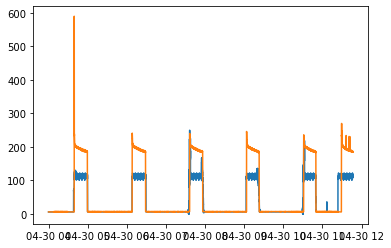

In [104]:
plt.plot(t6[:28000])
plt.plot(test_meter_medidor[:28000])

# Modelo 1 para micro ondas

In [191]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [192]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo microwave
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['microwave'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

In [193]:
train_meter

ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])

## Modelo 5
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [194]:
def auto_encoder5(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'linear'))
    model.add(Dropout(0.1))    
    #Aplanar la salida
    model.add(Flatten())
    

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 16 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Es un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [174]:
#<<<<
dae5 = auto_encoder5(sequence_length)

In [195]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado5 = dae5.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0012
Epoch 2/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0012
Epoch 3/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0015
Epoch 4/25
123/123 [==============================] - 10s 79ms/step - loss: 0.0015
Epoch 5/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0015
Epoch 6/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0015
Epoch 7/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0014
Epoch 8/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0013
Epoch 9/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0013
Epoch 10/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0015
Epoch 11/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0014
Epoch 12/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0013
Epoch 13/25


In [196]:
#<<<<<<
dae5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
dropout_56 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
dense_41 (Dense)             (None, 256, 8)            136       
_________________________________________________________________
dropout_57 (Dropout)         (None, 256, 8)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 4096)            

### Datos de test

In [197]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['microwave']

In [198]:
test_meter

ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])

In [199]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [200]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [201]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [205]:
#output_datastore5.close()

In [206]:
#<<<<<<<
output_datastore5 = pd.HDFStore("predict5_V3.h5", "w")
#output_datastore5.close()

In [207]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie >>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae5)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    
    #<<<<<<<
    output_datastore5.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore5.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [208]:
test_meter.instance()

11

In [209]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore5.keys()}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter11']


In [210]:
#<<<<<<<<
t9 = output_datastore5.get('/building1/elec/meter1')
t10 = output_datastore5.get('/building1/elec/meter11') #Prediccion
print(f"type(t6) {type(t8)}")
print(f"t6.shape {t8.shape}")

type(t6) <class 'pandas.core.frame.DataFrame'>
t6.shape (746138, 1)


In [211]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


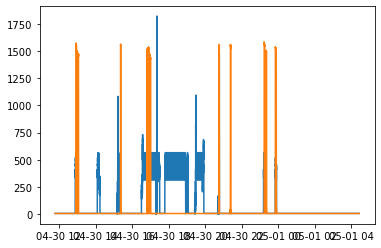

In [214]:
plt.plot(t10[28000:88000])
plt.plot(test_meter_medidor[28000:88000])

# V2 micro ondas

In [216]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [217]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['microwave'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

## Modelo 6
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [218]:
def auto_encoder6(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'linear'))
    model.add(Dropout(0.1))    
    #Aplanar la salida
    model.add(Flatten())
    

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 16 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Es un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [219]:
#<<<<
dae6 = auto_encoder6(sequence_length)

In [220]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado6 = dae6.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 10s 76ms/step - loss: 0.0016
Epoch 2/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0013
Epoch 3/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0013
Epoch 4/25
123/123 [==============================] - 10s 78ms/step - loss: 0.0014
Epoch 5/25
123/123 [==============================] - 9s 76ms/step - loss: 9.8883e-04
Epoch 6/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0011
Epoch 7/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0013
Epoch 8/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0015
Epoch 9/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0017
Epoch 10/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0016
Epoch 11/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0016
Epoch 12/25
123/123 [==============================] - 9s 77ms/step - loss: 0.0016
Epoch 1

In [221]:
#<<<<<<
dae6.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
dropout_64 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
dense_47 (Dense)             (None, 256, 8)            136       
_________________________________________________________________
dropout_65 (Dropout)         (None, 256, 8)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 4096)            

# Datos de test

In [222]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['microwave']

In [223]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [224]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [225]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [226]:
#output_datastore6.close()

In [227]:
#<<<<<<<
output_datastore6 = pd.HDFStore("predict6_V3.h5", "w")

In [228]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie 
    #>>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae6)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore6.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore6.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [230]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore6.keys()}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter11']


In [231]:
t11 = output_datastore6.get('/building1/elec/meter1')
t12 = output_datastore6.get('/building1/elec/meter11') #Prediccion
print(f"type(t6) {type(t12)}")
print(f"t6.shape {t12.shape}")

type(t6) <class 'pandas.core.frame.DataFrame'>
t6.shape (746138, 1)


In [232]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


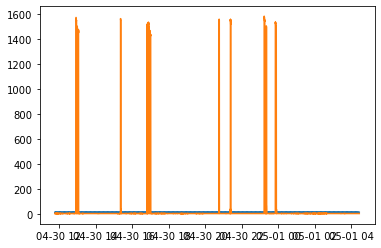

In [233]:
plt.plot(t12[28000:88000])                   #Azul
plt.plot(test_meter_medidor[28000:88000])   #Amarillo

# V3 Micro Ondas

In [234]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [235]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['microwave'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003066,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:49-04:00', '2011-04-29 23:59:50-04:00',
               '2011-04-29 23:59:51-04:00', '2011-04-29 23:59:52-04:00',
               '2011-04-29 23:59:53-04:00', '2011-04-29 23:59:54-04:00',
               '2011-04-29 23:59:55-04:00', '2011-04-29 23:59:56-04:00',
               '2011-04-29 23:59:57-04:00', '2011-04-29 23:59:58-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=1003066, freq='S')
X_batch (3919, 256, 1)
Y_ba

## Modelo 7
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [236]:
def auto_encoder7(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*8, activation='relu'))

    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [237]:
#<<<<
dae7 = auto_encoder7(sequence_length)

In [238]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado7 = dae7.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 5s 39ms/step - loss: 0.0015
Epoch 2/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0017
Epoch 3/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0014
Epoch 4/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0013
Epoch 5/25
123/123 [==============================] - 5s 41ms/step - loss: 0.0016
Epoch 6/25
123/123 [==============================] - 5s 41ms/step - loss: 0.0012
Epoch 7/25
123/123 [==============================] - 5s 41ms/step - loss: 0.0010
Epoch 8/25
123/123 [==============================] - 5s 41ms/step - loss: 9.9957e-04
Epoch 9/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0014
Epoch 10/25
123/123 [==============================] - 5s 40ms/step - loss: 9.2122e-04
Epoch 11/25
123/123 [==============================] - 5s 40ms/step - loss: 7.2173e-04
Epoch 12/25
123/123 [==============================] - 5s 41ms/step - loss: 8.6265e-

In [239]:
#<<<<<<
dae7.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 256, 8)            40        
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_73 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_74 (Dropout)         (None, 128)             

# Datos de test

In [240]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['microwave']

In [241]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [242]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [243]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [244]:
#output_datastore7.close()

In [245]:
#<<<<<<<
output_datastore7 = pd.HDFStore("predict7_V3.h5", "w")

In [246]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie 
    #>>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae7)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore7.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore7.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [247]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore7.keys()}")

output_datastore.keys() ['/building1/elec/meter1', '/building1/elec/meter11']


In [248]:
t13 = output_datastore7.get('/building1/elec/meter1')
t14 = output_datastore7.get('/building1/elec/meter11') #Prediccion
print(f"type(t6) {type(t12)}")
print(f"t6.shape {t12.shape}")

type(t6) <class 'pandas.core.frame.DataFrame'>
t6.shape (746138, 1)


In [249]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

type(test_meter_medidor) <class 'pandas.core.series.Series'>


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


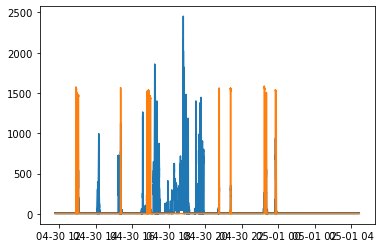

In [250]:
plt.plot(t14[28000:88000])
plt.plot(test_meter_medidor[28000:88000])

# washer dryer

### V1 washer dryer

In [269]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [270]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['washer dryer'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003067,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:50-04:00', '2011-04-29 23:59:51-04:00',
               '2011-04-29 23:59:52-04:00', '2011-04-29 23:59:53-04:00',
               '2011-04-29 23:59:54-04:00', '2011-04-29 23:59:55-04:00',
               '2011-04-29 23:59:56-04:00', '2011-04-29 23:59:57-04:00',
               '2011-04-29 23:59:58-04:00', '2011-0

## Modelo 8
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [271]:
def auto_encoder8(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*8, activation='relu'))

    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [272]:
#<<<<
dae8 = auto_encoder8(sequence_length)

In [273]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado8 = dae8.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0022
Epoch 2/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0023
Epoch 3/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0019
Epoch 4/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0014
Epoch 5/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0015
Epoch 6/25
123/123 [==============================] - 5s 40ms/step - loss: 0.0023
Epoch 7/25
123/123 [==============================] - 5s 42ms/step - loss: 0.0022
Epoch 8/25
123/123 [==============================] - 5s 41ms/step - loss: 0.0014
Epoch 9/25
123/123 [==============================] - 5s 42ms/step - loss: 0.0011
Epoch 10/25
123/123 [==============================] - 6s 46ms/step - loss: 0.0014
Epoch 11/25
123/123 [==============================] - 6s 47ms/step - loss: 6.9005e-04
Epoch 12/25
123/123 [==============================] - 5s 43ms/step - loss: 0.0013
Epoch 13/

In [274]:
#<<<<<<
dae8.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 256, 8)            40        
_________________________________________________________________
flatten_14 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_81 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_82 (Dropout)         (None, 128)             

# Datos de test

In [276]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['washer dryer']

In [277]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [278]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [279]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [280]:
#output_datastore8.close()

In [281]:
#<<<<<<<
output_datastore8 = pd.HDFStore("predict8_V3.h5", "w")

In [282]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie 
    #>>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae8)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore8.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore8.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'meter(10, 20)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [283]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore8.keys()}")

output_datastore.keys() ['/building1/elec/meter(10, 20)', '/building1/elec/meter1']


In [286]:
#<<<<<<<
t15 = output_datastore8.get('/building1/elec/meter(10, 20)')
t16 = output_datastore8.get('/building1/elec/meter(10, 20)') #Prediccion
print(f"type(t16) {type(t16)}")
print(f"t16.shape {t16.shape}")

type(t16) <class 'pandas.core.frame.DataFrame'>
t16.shape (746138, 1)


In [287]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
type(test_meter_medidor) <class 'pandas.core.series.Series'>


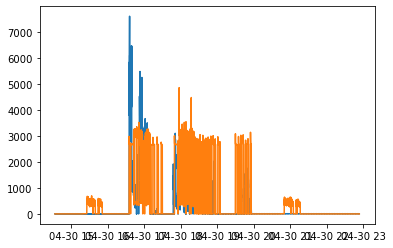

In [291]:
plt.plot(t16[38000:68000])                #Amarillo
plt.plot(test_meter_medidor[38000:68000]) #Azul

### V2 washer dryer

In [292]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [293]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['washer dryer'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003067,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:50-04:00', '2011-04-29 23:59:51-04:00',
               '2011-04-29 23:59:52-04:00', '2011-04-29 23:59:53-04:00',
               '2011-04-29 23:59:54-04:00', '2011-04-29 23:59:55-04:00',
               '2011-04-29 23:59:56-04:00', '2011-04-29 23:59:57-04:00',
               '2011-04-29 23:59:58-04:00', '2011-0

## Modelo 9
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [294]:
def auto_encoder9(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    model.add(Dense((sequence_len-0)*16, activation='relu'))

    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [295]:
#<<<<
dae9 = auto_encoder9(sequence_length)

In [296]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado9 = dae9.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 9s 72ms/step - loss: 0.0022
Epoch 2/25
123/123 [==============================] - 9s 72ms/step - loss: 0.0015
Epoch 3/25
123/123 [==============================] - 9s 72ms/step - loss: 0.0013
Epoch 4/25
123/123 [==============================] - 11s 87ms/step - loss: 0.0015
Epoch 5/25
123/123 [==============================] - 10s 82ms/step - loss: 8.9521e-04
Epoch 6/25
123/123 [==============================] - 11s 87ms/step - loss: 0.0017
Epoch 7/25
123/123 [==============================] - 10s 80ms/step - loss: 0.0017
Epoch 8/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0017
Epoch 9/25
123/123 [==============================] - 9s 73ms/step - loss: 0.0040
Epoch 10/25
123/123 [==============================] - 9s 71ms/step - loss: 0.0019
Epoch 11/25
123/123 [==============================] - 9s 71ms/step - loss: 0.0026
Epoch 12/25
123/123 [==============================] - 9s 72ms/step - loss: 0.0023
Epoch

In [297]:
#<<<<<<
dae9.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
flatten_15 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_85 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_86 (Dropout)         (None, 128)             

# Datos de test

In [298]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['washer dryer']

In [299]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [300]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [301]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [302]:
#output_datastore8.close()

In [303]:
#<<<<<<<
output_datastore9 = pd.HDFStore("predict9_V3.h5", "w")

In [304]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie 
    #>>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae9)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore9.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore9.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'meter(10, 20)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [305]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore9.keys()}")

output_datastore.keys() ['/building1/elec/meter(10, 20)', '/building1/elec/meter1']


In [306]:
#<<<<<<<
t17 = output_datastore8.get('/building1/elec/meter(10, 20)')
t18 = output_datastore8.get('/building1/elec/meter(10, 20)') #Prediccion
print(f"type(t18) {type(t18)}")
print(f"t18.shape {t18.shape}")

type(t18) <class 'pandas.core.frame.DataFrame'>
t18.shape (746138, 1)


In [307]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
type(test_meter_medidor) <class 'pandas.core.series.Series'>


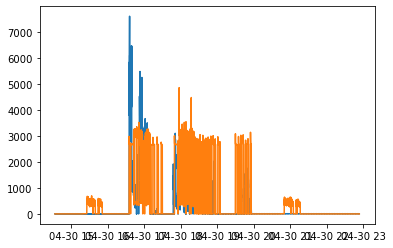

In [308]:
plt.plot(t18[38000:68000])                #Amarillo
plt.plot(test_meter_medidor[38000:68000]) #Azul

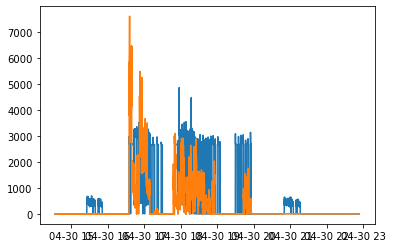

In [329]:
plt.plot(test_meter_medidor[38000:68000])
plt.plot(t18[38000:68000])

### V3 washer dryer

In [309]:
# Una estructura con 256 pasos en el tamaño de la muestra
sequence_length = 256

In [310]:
#1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

#3. Carga como medidor de entrenamiento el medidor central y el medidor para un dispositivo Fridge
train_mains = train_elec.mains().all_meters()[0] # El medidor agregado o central que proporciona la entrada
train_meter = train_elec.submeters()['washer dryer'] # El medidor de microondas que se utiliza como objetivo de entrenamiento.
#4. Cargar los datos de las series definidas
# Frecuencia de la muestra
load_kwargs = {'sample_period': 1}
# Esta función crea un generador de datos, si es necesario la remuestrea
# al periodo de tiempo definida por el usuario
main_power_series = train_mains.power_series(**load_kwargs)
meter_power_series = train_meter.power_series(**load_kwargs)

#5. Con next des empaqueta los datos en series de pandas antes definidas por un generador
mainchunk = next(main_power_series)          # Datos del medidor central
meterchunk = next(meter_power_series)        # Datos del electrodomestico

print(f"mainchunk tipo = {type(mainchunk)} tamaño = {mainchunk.shape}")
print(f"meterchunk tipo = {type(meterchunk)} tamaño = {meterchunk.shape}")

#6. Calcula el valor maximo del medidor central
mmax = None
if mmax == None:
    mmax = mainchunk.max()
mmax

#7. Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

#8. #Normaliza las series
mainchunk = _normalize(mainchunk, mmax)
meterchunk = _normalize(meterchunk, mmax)
mainchunk.head(5)

#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
mainchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003071,)
meterchunk tipo = <class 'pandas.core.series.Series'> tamaño = (1003067,)
DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:50-04:00', '2011-04-29 23:59:51-04:00',
               '2011-04-29 23:59:52-04:00', '2011-04-29 23:59:53-04:00',
               '2011-04-29 23:59:54-04:00', '2011-04-29 23:59:55-04:00',
               '2011-04-29 23:59:56-04:00', '2011-04-29 23:59:57-04:00',
               '2011-04-29 23:59:58-04:00', '2011-0

## Modelo 10
Por dinamismo creare los modelos a modo de funciones, de esta manera puedo guardar un modelo dentro de una variable que puedo invocar dentro de otras funciones. 

Agregando mas capas densas intermedias

In [313]:
def auto_encoder10(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(16, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'linear'))
    model.add(Dropout(0.1))    
    #Aplanar la salida
    model.add(Flatten())
    

    #Auto encoder
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    # Neuronas 16 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    
    model.add(Dense((sequence_len-0)*16, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 16)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Es un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [314]:
#<<<<
dae10 = auto_encoder10(sequence_length)

In [315]:
# Entrenar el modelo
train_mains = X_batch 
train_meter = Y_batch 
#<<<<
modelo_entrenado10 = dae10.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 10s 75ms/step - loss: 0.0019
Epoch 2/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0016
Epoch 3/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0019
Epoch 4/25
123/123 [==============================] - 10s 78ms/step - loss: 0.0026
Epoch 5/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0026
Epoch 6/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0027
Epoch 7/25
123/123 [==============================] - 9s 76ms/step - loss: 0.0022
Epoch 8/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0016
Epoch 9/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0025
Epoch 10/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0017
Epoch 11/25
123/123 [==============================] - 9s 75ms/step - loss: 0.0032
Epoch 12/25
123/123 [==============================] - 10s 78ms/step - loss: 0.0023
Epoch 13/2

In [316]:
#<<<<<<
dae10.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 256, 16)           80        
_________________________________________________________________
dropout_96 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
dense_71 (Dense)             (None, 256, 8)            136       
_________________________________________________________________
dropout_97 (Dropout)         (None, 256, 8)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_98 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 4096)            

# Datos de test

In [317]:
#14. Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#15. Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
#16. Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
#17. Selecciona el medidor central del edificio
test_mains = test_elec.mains().all_meters()[0]
test_meter = test_elec.submeters()['washer dryer']

In [318]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

#19. Crea un string con el nombre del edificio mas el id del edificio que lo
#toma desde los metadatos 
#ejemplo building1
building_path = '/building{}'.format(test_mains.building())
#20. Ahora crea el nombre de la ruta al medidor 1 del edificio en cuestión
#Pej.  building1/elec/meter1
mains_data_location = building_path + '/elec/meter1'

#21. Variable de control datos estan disponibles
data_is_available = False

In [319]:
#22. Verificar los tiempos de buen funcionamiento del medidor central
load_kwargs.setdefault('sections', test_mains.good_sections())

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [320]:
#23. Defino una lista que contendra los instantes de buen funcionamiento 
# que cumplan con el tamaño de muestra
timeframes = []

In [321]:
#output_datastore8.close()

In [322]:
#<<<<<<<
output_datastore10 = pd.HDFStore("predict10_V3.h5", "w")

In [323]:
#24. Recorro todas los tramos de test para el medidor central en buen funcionamiento
MIN_CHUNK_LENGTH = sequence_length #Tamaño del paso de ventana
id_serie = 0
for chunk in test_mains.power_series(**load_kwargs):
    #25. Si el tamaño de la serie cargada es menor al de las ventanas se descarta
    if len(chunk) < MIN_CHUNK_LENGTH:
        continue
    #26. Imprime el tamaño de los tramos de series cargados
    print("New sensible chunk: {} size of data".format(len(chunk)))
    
    # Se guarda cada tramo de tiempo seleccionado
    timeframes.append(chunk.timeframe)
    # Nombre de las columnas de series de datos ('power', 'apparent')
    measurement = chunk.name
    
    # Normaliza la serie chunk del medidor central cargada y la guarda en una nueva variable usando como
    # maximo el valor del medidor centrar de entrenamiento
    chunk2 = _normalize(chunk, mmax)

    #Ahora debo crear una base de datos con las formas adecuadas para cada chunk
    #cree una función que guarda las series en un archivo hdf5
    #requiere el numero de la serie iniciando en 0 para usarla como id
    
    #llamar funcion, pasar chunk2 y el id_serie 
    #>>>>>>>>>>>>>>>>>>>
    appliance_power = data_predict(chunk2, id_serie, dae10)
    
    # Todo valor negativo calculado lo iguala a cero
    appliance_power[appliance_power < 0] = 0
    
    # Calcula el valor real mediante la desnormalización de los datos
    appliance_power = _denormalize(appliance_power, mmax)
    
    # Convierte lista de tuplas a MultiIndex osea una estructura que contiene
    # multiples indices. Lons nombres estan dados pos la serie main original
    # chunk.name = ('power', 'apparent') 
    # cols = MultiIndex([('power', 'apparent')]
    cols = pd.MultiIndex.from_tuples([chunk.name])
    
    # De los metadatos extrae el valor de la instancia de la medida
    # que en si es como el id del dispositivo por ejemplo 5 para refrigerador
    # en el edificio 1. Siempre es el del electrodomestico
    meter_instance = test_meter.instance()
    
    # Ahora crea un df para cada serie predicha chunk con: 
    # appliance_power.values = los valores de la serie predicha
    # index=appliance_power.index con indice el tiempo de dicha serie
    # columns=cols da el nombre de las columnas ('power', 'apparent') es el nombre 
    # de la columna de medidas, el indice no tiene nombre
    # y define los datos como  de punto flotante
    df = pd.DataFrame(
        appliance_power.values, index=appliance_power.index,
        columns=cols, dtype="float32")

    # Define el nombre de la ruta de cada dispositivo /building1/elec/meter5 predicho
    # Esta es la clave de los datos procesados para guardar en el h5 
    # Esta clave se mantiene igual para cada tramo chunk que se haga la predicción
    key = '{}/elec/meter{}'.format(building_path, meter_instance)

    # En el archivo output_datastore4 se agregaran los datos calculados en 
    # cada predicción es el archivo hdf5 definido en el programa principal
    # Para cada clave '/building1/elec/meter5' agrega el df
    # Primero para la serie calculada para el electrodomestico '/building1/elec/meter5'
    #<<<<<<<
    output_datastore10.append(key, df)
    
    # Ahora tomo los datos del medidor objetivo pero de test
    
    

    # Append aggregate data to output / Agregar datos agregados a la salida
    # Crea un dataframe para la serie de datos del medidor central original
    mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
    # Y tambien la agrega al archivo de salidas calculadas quedando en orden
    # datos predichos y luego datos originales del medidor con clave '/building1/elec/meter1'
    # Al hacerlo de este modo cada nuevo df se agrega debajo del anterior segun el nombre de sus
    # columnas. Deben tener el mismo nombre y orden para que se haga el match
    #<<<<<<<
    output_datastore10.append(key=mains_data_location, value=mains_df)

New sensible chunk: 121482 size of data


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'meter(10, 20)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [324]:
#<<<<<<<
print(f"output_datastore.keys() {output_datastore10.keys()}")

output_datastore.keys() ['/building1/elec/meter(10, 20)', '/building1/elec/meter1']


In [325]:
#<<<<<<<
t19 = output_datastore8.get('/building1/elec/meter(10, 20)')
t20 = output_datastore8.get('/building1/elec/meter(10, 20)') #Prediccion
print(f"type(t18) {type(t18)}")
print(f"t18.shape {t18.shape}")

type(t18) <class 'pandas.core.frame.DataFrame'>
t18.shape (746138, 1)


In [326]:
test_meter_medidor = test_meter.power_series(**load_kwargs) #Real
test_meter_medidor = next(test_meter_medidor)
print(f"type(test_meter_medidor) {type(test_meter_medidor)}")

Loading data for meter ElecMeterID(instance=10, building=1, dataset='REDD')     

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
type(test_meter_medidor) <class 'pandas.core.series.Series'>


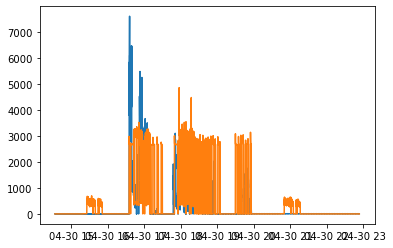

In [327]:
plt.plot(t20[38000:68000])                 #Amarillo
plt.plot(test_meter_medidor[38000:68000])  #Azul

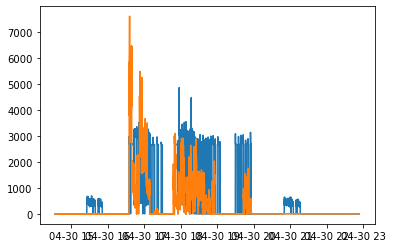

In [328]:
plt.plot(test_meter_medidor[38000:68000]) 
plt.plot(t20[38000:68000])